In [46]:
import pandas as pd
import numpy as np
import sklearn
import os

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn import tree, linear_model
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score

In [2]:
# импортируем таблицу
table = pd.read_csv('table.csv', index_col='index')

In [3]:
# смотрим на структуру получившейся таблицы
table.head()

,Score,Action
index,,
0,0.00,operator
1,19.55,reask
2,24.34,reask
3,29.26,reask
4,0.00,operator


In [4]:
# несколько проверок на наличие косяков в данных: максимальный и минимальный score, количество уникальных действий
# и наличие пропусков в таблице

In [5]:
table['Score'].max()

100.0

In [6]:
table['Score'].min()

0.0

In [7]:
table['Action'].unique()

array(['operator', 'reask', 'correct'], dtype=object)

In [8]:
table.isna().values.any()

False

In [9]:
# конвертируем score в понятный scikit-learn формат и масштабируем
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(table['Score'].to_numpy().reshape(-1, 1))

In [ ]:
# выбираем классификатор с помощью кросс-валидации. Попробуем решающее дерево и логистическую регрессию
# поскольку бизнес-логика нам неизвестна, в качестве метрик будем использовать balanced accuracy и f1

In [34]:
clf_tree = tree.DecisionTreeClassifier(max_depth=2, class_weight='balanced')
scores = cross_val_score(clf_tree, X_train, table['Action'], cv=10, scoring='f1_weighted')
print("Tree classifier has %0.2f f1 score with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
scores = cross_val_score(clf_tree, X_train, table['Action'], cv=10, scoring='balanced_accuracy')
print("Tree classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Tree classifier has 0.62 f1 score with a standard deviation of 0.09
Tree classifier has 0.71 accuracy with a standard deviation of 0.08


In [36]:
clf_logreg = linear_model.LogisticRegression(class_weight='balanced')
scores = cross_val_score(clf_logreg, X_train, table['Action'], cv=10, scoring='f1_weighted')
print("Logistic regression classifier has %0.2f f1 score with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
scores = cross_val_score(clf_logreg, X_train, table['Action'], cv=10, scoring='balanced_accuracy')
print("Logistic regression classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Logistic regression classifier has 0.57 f1 score with a standard deviation of 0.08
Logistic regression classifier has 0.68 accuracy with a standard deviation of 0.08


In [44]:
# Метрики решающих деревьев чуть лучше, обучаем классфикатор
clf_tree = tree.DecisionTreeClassifier(max_depth=2, class_weight='balanced')
clf_tree = clf_tree.fit(X_train, table['Action'])

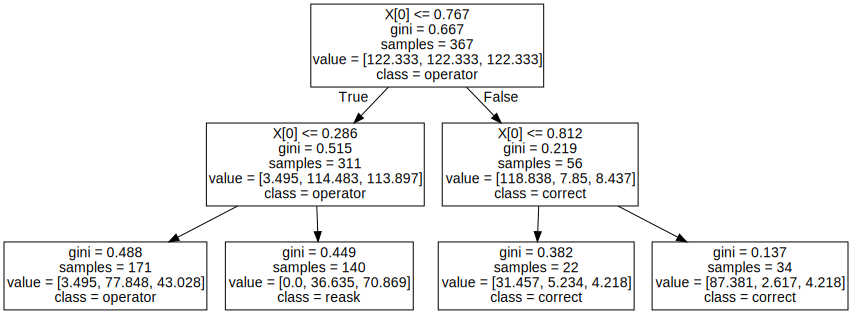

In [45]:
# Визуализируем
import graphviz 
dot_data = tree.export_graphviz(clf_tree, out_file=None, class_names=['correct', 'operator', 'reask']) 
graph = graphviz.Source(dot_data) 
graph

In [50]:
# Посчитаем balanced accuracy для обученного дерева
y_pred = clf_tree.predict(X_train)
accuracy = balanced_accuracy_score(table['Action'], y_pred)
print("Tree classifier has %0.2f accuracy on the training data" % (accuracy))

Tree classifier has 0.73 accuracy on the training data


In [37]:
# Классификатор очень простой, поэтому таскать его в виде объекта scikit-learn необязательно
def decide(score):
    if score > 100:
        raise ValueError('Score is greater than 100')
    if score < 0:
        raise ValueError('Score is negative')
    if score > 76.7:
        return 'correct'
    elif score > 28.6:
        return 'reask'
    else:
        return 'operator'    